# Figure 9

## Imports

In [18]:
import matplotlib.pyplot as plt
import numpy
import os
import dolfin
import meshio
import shutil

import dolfin_mech                    as dmech
import get_invariants

## Creating folder for temporary files

In [19]:
current_directory=os.getcwd()
new_directory="calc_fig9"
res_basename = os.path.join(current_directory, new_directory)

try:
    shutil.rmtree(res_basename)
except OSError:
    pass

os.mkdir(res_basename)

clean_upon_completion=True

## Parameters

### Mesh

In [20]:
cube_params = {"path_and_mesh_name" : str(current_directory)+"/Meshes/generic_lung.xdmf"}

### Material

In [21]:
params = {
    "alpha": 0.16, ### kPa
    "gamma":0.5, ### [-]
    "c1":0.6, ### kPa
    "c2":0., ## kPa, but obsolete parameter
    "kappa":1e2,  ### kPa
    "eta":1e-5,   ### [-]
    "rho_solid":1e-6} ### g/mm3

mat_params = {"scaling":"linear", "parameters":params}

## Loading

In [22]:
pe, pi = -0.5, -2. # kPa

g = 9.81e3 # mm/s2

## Computing strain fields in prone and supine positions

In [23]:
invariants = {}

gravity_lst = [-1.,+1.]
for gravity_cste in gravity_lst:

    load_params_inverse = {
        "type":"p_boundary_condition0", "f": gravity_cste*9.81e3, "P0":float(pe)}
    load_params_direct_exhalation = {
        "type":"p_boundary_condition", "f": gravity_cste*9.81e3, "P0":float(pe)}
    load_params_direct_inhalation = {
        "type":"p_boundary_condition", "f": gravity_cste*9.81e3, "P0":float(pi)}

    ### computing the unloaded configuration
    Uref, phisref_computation, dV_expi_ini = dmech.run_RivlinCube_PoroHyperelasticity(
        inverse=1,
        mat_params=mat_params,
        load_params=load_params_inverse,
        get_results=1,
        inertia_params={"applied":True, "rho_val":1e-8},
        step_params={"dt_min":1e-4, "dt_ini":1},
        res_basename=res_basename+"/reference",
        cube_params=cube_params,
        verbose=1)

    ### computing the end-exhalation configuration
    phisref_imposed = [numpy.random.uniform(low=0.4, high=0.6) for i in range(len(phisref_computation))]
    U_exhal, phisexhal_g, dV_unloaded = dmech.run_RivlinCube_PoroHyperelasticity(
        inverse=0,
        mat_params=mat_params,
        load_params=load_params_direct_exhalation,
        get_results=1,
        inertia_params={"applied":True, "rho_val":1e-8},
        step_params={"dt_min":1e-4, "dt_ini":0.125},
        res_basename = res_basename+"/exhalation",
        cube_params=cube_params,
        porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
        move_params = {"move":True, "U":Uref},
        verbose=1)

    U_inhal, phisinhal, dV_unloaded = dmech.run_RivlinCube_PoroHyperelasticity(
        inverse=0,
        mat_params=mat_params,
        load_params=load_params_direct_inhalation,
        get_results=1,
        inertia_params={"applied":True, "rho_val":1e-8},
        step_params={"dt_min":1e-4, "dt_ini":0.125},
        res_basename = res_basename+"/inhalation",
        cube_params=cube_params,
        porosity_params={"type": "function_xml_from_array", "val":phisref_imposed},
        move_params = {"move":True, "U":Uref},
        verbose=1)

    mesh = dolfin.Mesh()
    mesh_name = str(cube_params["path_and_mesh_name"])
    dolfin.XDMFFile(mesh_name).read(mesh)
    dolfin.ALE.move(mesh, Uref)

    invariants_mesh = get_invariants.get_invariants(U_exhal=U_exhal, U_inhal=U_inhal, mesh=mesh, lognorm=False)
    invariants["g="+str(gravity_cste)] = invariants_mesh

Iterating over subset, found 309 entities out of 4052.
Iterating over subset, found 275 entities out of 4052.
Iterating over subset, found 328 entities out of 4052.
Iterating over subset, found 344 entities out of 4052.
Iterating over subset, found 380 entities out of 4052.
Iterating over subset, found 484 entities out of 4052.
Iterating over subset, found 454 entities out of 4052.
Iterating over subset, found 522 entities out of 4052.
Iterating over subset, found 476 entities out of 4052.
Iterating over subset, found 480 entities out of 4052.
Iterating over subset, found 365 entities out of 4052.
Iterating over subset, found 277 entities out of 4052.
Iterating over subset, found 315 entities out of 4052.
Iterating over subset, found 361 entities out of 4052.
Iterating over subset, found 438 entities out of 4052.
Iterating over subset, found 454 entities out of 4052.
Iterating over subset, found 466 entities out of 4052.
Iterating over subset, found 520 entities out of 4052.
Iterating 

## Post-processing

### Reading displacement field from Patte et al. and computing associated invariants

In [24]:
mesh = dolfin.Mesh()
dolfin.XDMFFile("Meshes/mesh_patte.xdmf").read(mesh)
fe = dolfin.VectorElement(
    family="CG",
    cell=mesh.ufl_cell(),
    degree=1)
U_fs= dolfin.FunctionSpace(
    mesh,
    fe)

U_inhal_patte = dolfin.Function(U_fs, name="U")
U_exhal_patte = dolfin.Function(U_fs, name="U")

mesh_meshio = meshio.read("Meshes/mesh_patte.xdmf")
u_meshio = mesh_meshio.point_data["U"]
u_meshio = u_meshio.tolist()
u_meshio = [item for sublist in u_meshio for item in sublist] 

c = 0
for dof in dolfin.vertex_to_dof_map(U_fs):
    U_inhal_patte.vector()[dof] = u_meshio[c]
    U_exhal_patte.vector()[dof] = 0.
    c += 1

In [25]:
invariants_mesh_patte = get_invariants.get_invariants(U_exhal=U_exhal_patte, U_inhal=U_inhal_patte, mesh=mesh, lognorm=False)

Iterating over subset, found 375 entities out of 4052.
Iterating over subset, found 314 entities out of 4052.
Iterating over subset, found 315 entities out of 4052.
Iterating over subset, found 329 entities out of 4052.
Iterating over subset, found 384 entities out of 4052.
Iterating over subset, found 440 entities out of 4052.
Iterating over subset, found 425 entities out of 4052.
Iterating over subset, found 520 entities out of 4052.
Iterating over subset, found 453 entities out of 4052.
Iterating over subset, found 497 entities out of 4052.


### Generating plots

#### I1

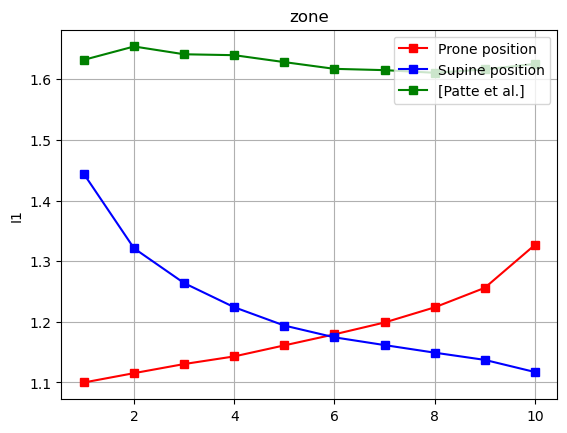

In [26]:
fig, ax = plt.subplots()
plt.plot(invariants["g=-1.0"]["zone"]   , invariants["g=-1.0"]["I1"]   , color="red"  , linestyle="-", marker="s", label="Prone position" )
plt.plot(invariants["g=1.0"]["zone"]    , invariants["g=1.0"]["I1"]    , color="blue" , linestyle="-", marker="s", label="Supine position")
plt.plot(invariants_mesh_patte["zone"], invariants_mesh_patte["I1"], color="green", linestyle="-", marker="s", label="[Patte et al.]" )
ax.set_ylabel("I1")
ax.set_title("zone")
plt.legend(loc="upper right")
plt.grid()
plt.show()

#### I2

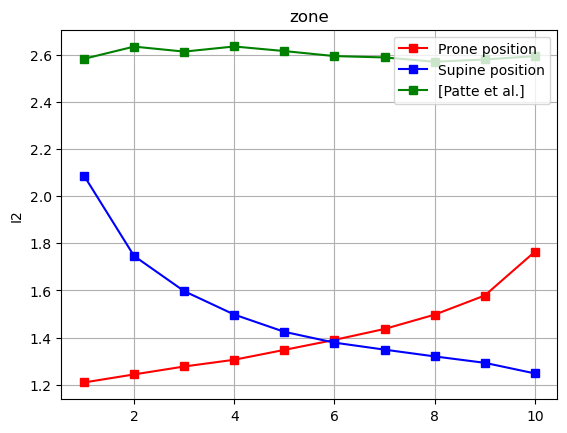

In [27]:
fig, ax = plt.subplots()
plt.plot(invariants["g=-1.0"]["zone"]   , invariants["g=-1.0"]["I2"]   , color="red"  , linestyle="-", marker="s", label="Prone position" )
plt.plot(invariants["g=1.0"]["zone"]    , invariants["g=1.0"]["I2"]    , color="blue" , linestyle="-", marker="s", label="Supine position")
plt.plot(invariants_mesh_patte["zone"], invariants_mesh_patte["I2"], color="green", linestyle="-", marker="s", label="[Patte et al.]" )
ax.set_ylabel("I2")
ax.set_title("zone")
plt.legend(loc="upper right")
plt.grid()
plt.show()

#### J

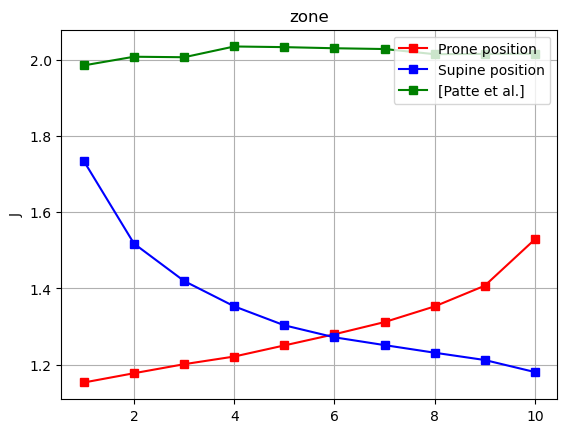

In [28]:
fig, ax = plt.subplots()
plt.plot(invariants["g=-1.0"]["zone"]   , invariants["g=-1.0"]["J"]   , color="red"  , linestyle="-", marker="s", label="Prone position" )
plt.plot(invariants["g=1.0"]["zone"]    , invariants["g=1.0"]["J"]    , color="blue" , linestyle="-", marker="s", label="Supine position")
plt.plot(invariants_mesh_patte["zone"], invariants_mesh_patte["J"], color="green", linestyle="-", marker="s", label="[Patte et al.]" )
ax.set_ylabel("J")
ax.set_title("zone")
plt.legend(loc="upper right")
plt.grid()
plt.show()